# Mapas Coropléticos en Python (GeoPandas + PySAL)

Este cuaderno explica, de forma **práctica y matemática**, cómo construir mapas coropléticos:
- cómo elegir la **variable** correcta (tasas vs. conteos),
- cómo **clasificar** los datos (intervalos, cuantiles, Jenks/Fisher–Jenks),
- cómo estimar el **número de clases** con la **regla de Freedman–Diaconis**


## Requisitos

Este cuaderno usa librerías de SIG en Python:

- `geopandas` (lectura/plot de datos espaciales)
- `mapclassify` (esquemas de clasificación para coropletas)
- `libpysal` y `esda` (autocorrelación espacial)
- `matplotlib` y `numpy`



In [1]:
# !pip install geopandas mapclassify libpysal esda matplotlib numpy shapely pyproj


In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import mapclassify as mc
from libpysal.weights import Queen
from esda.moran import Moran

# Evitar warnings visuales y asegurar estilo simple
plt.rcParams['figure.figsize'] = (8, 6)


## Fundamentos matemáticos mínimos

### Asignación de clases
Sea una variable cuantitativa asociada a cada polígono $i$, denotada por $y_i$.
Dividimos el dominio de $y$ en clases $C_j$ con límites $(c_j, c_{j+1})$ tales que

$$
c_j < y_i \le c_{j+1} \quad \forall\, y_i \in C_j, \quad j=1,\dots,k.
$$

### Regla de Freedman–Diaconis (FD) para el ancho de clase
Para un conjunto de datos unidimensional \(y\) de tamaño \(n\), el **ancho** óptimo se aproxima por

$$
w \;=\; 2 \cdot IQR(y) \cdot n^{-1/3},
$$

donde $IQR = Q_3 - Q_1$. Si usamos $w$ para particionar el rango $(\min(y), \max(y))$, el **número de clases** propuesto es

$$
k \;=\;  \frac{\max(y) - \min(y)}{w}.
$$



## Dataset público: *Natural Earth* (incluido en GeoPandas)

Usaremos el conjunto **`naturalearth_lowres`** (países del mundo) que viene con GeoPandas.  
Calcularemos **PIB per cápita** como variable de ejemplo y generaremos varios mapas coropléticos.


In [3]:
# Cargar Natural Earth (incluido en GeoPandas, no requiere internet)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Limpiezas mínimas
world = world[(world.pop_est > 0) & (world.name != 'Antarctica')].copy()

# Variable de ejemplo: PIB per cápita en USD (gdp_md_est está en millones)
world['gdp_pc'] = (world['gdp_md_est'] * 1_000_000) / world['pop_est']

world[['name', 'continent', 'pop_est', 'gdp_md_est', 'gdp_pc']].head()


/var/folders/kg/plkd97154_zf916xg8gj219h0000gn/T/ipykernel_4352/3023982553.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,name,continent,pop_est,gdp_md_est,gdp_pc
0,Fiji,Oceania,889953.0,5496,6175.607026
1,Tanzania,Africa,58005463.0,63177,1089.156033
2,W. Sahara,Africa,603253.0,907,1503.515109
3,Canada,North America,37589262.0,1736425,46194.708478
4,United States of America,North America,328239523.0,21433226,65297.517508


## Visualización base de la variable

Antes de clasificar, inspeccionemos la distribución de `gdp_pc` para entender su sesgo y valores extremos.


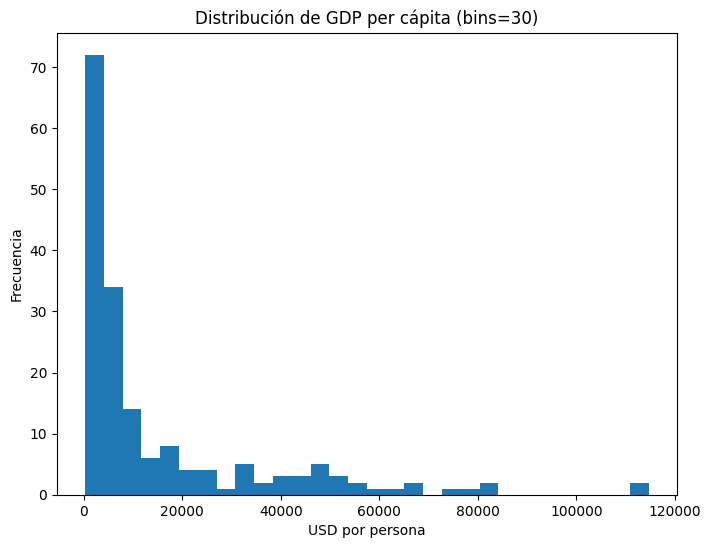

In [4]:
x = world['gdp_pc'].dropna().values

fig = plt.figure()
plt.hist(x, bins=30)
plt.title('Distribución de GDP per cápita (bins=30)')
plt.xlabel('USD por persona'); plt.ylabel('Frecuencia')
plt.show()


### Número de clases propuesto por Freedman–Diaconis

Calculamos \(w\) y \(k\) siguiendo la regla FD y usamos ese \(k\) como punto de partida para un mapa con **intervalos iguales**.


In [5]:
def freedman_diaconis_k(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    if n < 2:
        return 1
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    w = 2 * iqr * n ** (-1/3)
    if w <= 0:
        return int(np.sqrt(n))  # fallback
    k = int(np.ceil((x.max() - x.min()) / w))
    return max(1, min(k, 12))  # limitar por legibilidad

k_fd = freedman_diaconis_k(world['gdp_pc'].values)
k_fd


12

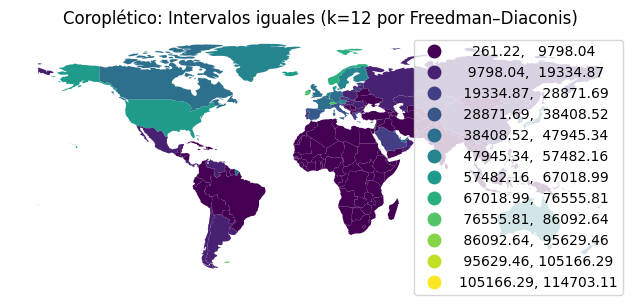

In [6]:
# Mapa con intervalos iguales usando k de FD
ax = world.plot(column='gdp_pc',
                scheme='equal_interval',
                k=k_fd,
                legend=True)
ax.set_title(f'Coroplético: Intervalos iguales (k={k_fd} por Freedman–Diaconis)')
ax.set_axis_off()
plt.show()


## Comparación de esquemas de clasificación

Mostramos **tres** esquemas populares (mismo `k` para comparar):
- **`quantiles`**: cada clase contiene ~el mismo número de polígonos.
- **`equal_interval`**: clases con el mismo ancho en el eje de valores.
- **`FisherJenks`** (*Jenks*): minimiza la varianza intra-clase y maximiza la inter-clase.


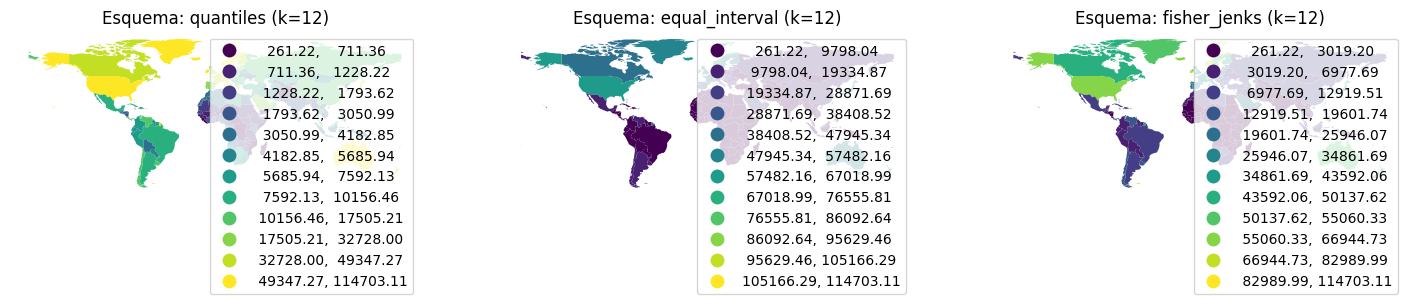

In [7]:
schemes = ['quantiles', 'equal_interval', 'fisher_jenks']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, scheme in zip(axes, schemes):
    world.plot(column='gdp_pc', scheme=scheme, k=k_fd, legend=True, ax=ax)
    ax.set_title(f'Esquema: {scheme} (k={k_fd})')
    ax.set_axis_off()

plt.show()


## Tasas vs. conteos (¡evitar sesgos visuales!)

En coropletas se deben mapear **tasas/razones** (p. ej., *PIB per cápita*), **no conteos brutos** (*PIB total*), para no confundir **tamaño del área** con **intensidad** del fenómeno.

Sea $z_i$ un conteo y $a_i$ una población/área base; entonces una tasa típica es

$$
r_i \;=\; \frac{z_i}{a_i}.
$$

En este cuaderno usamos `gdp_pc` (*PIB per cápita*) en lugar de `gdp_md_est`.


## Sensibilidad al número de clases \(k\)

Compara cómo cambia el mapa al variar \(k\). No existe un \(k\) universal; FD da un **punto de partida** razonable.


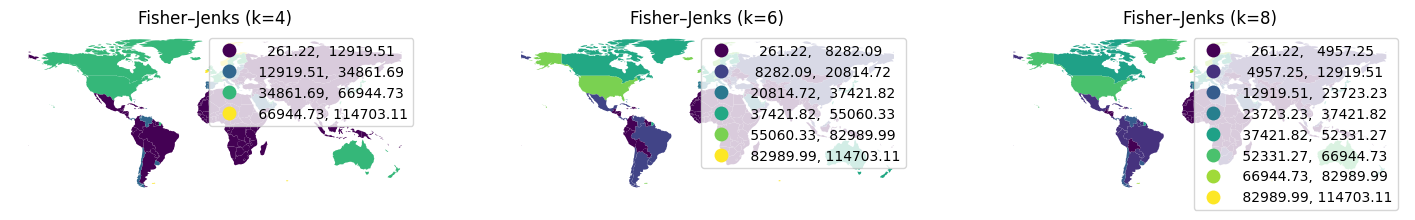

In [8]:
ks = [4, 6, 8]
fig, axes = plt.subplots(1, len(ks), figsize=(18, 5))
for ax, k in zip(axes, ks):
    world.plot(column='gdp_pc', scheme='fisher_jenks', k=k, legend=True, ax=ax)
    ax.set_title(f'Fisher–Jenks (k={k})')
    ax.set_axis_off()
plt.show()


## Ejemplo hurtos

In [17]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
# Cargar datos de hurtos
df = pd.read_csv("./data/hurto_a_residencia.csv")
# Cargar polígonos (barrios/veredas)
barrios = gpd.read_file("./data/barrios_y_veredas_mr.geojson")

In [5]:
df.keys()

Index(['fecha_hecho', 'cantidad', 'latitud', 'longitud', 'sexo', 'edad',
       'estado_civil', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'medio_transporte',
       'nivel_academico', 'testigo', 'conducta', 'modalidad',
       'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal',
       'categoria_penal', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna',
       'lugar', 'sede_receptora', 'bien', 'categoria_bien', 'grupo_bien',
       'modelo', 'color', 'permiso', 'unidad_medida', 'fecha_ingestion'],
      dtype='object')

In [13]:
df.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion
0,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Accesorios prendas de vestir,Prendas de vestir y accesorios,Mercancía,-1,Oro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
1,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Electrodoméstico video y audio y accesorios,Electrodomésticos,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
2,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Celular,Tecnología,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
3,2017-01-01T00:00:00.000-05:00,1.0,6.262758,-75.593850,Hombre,62,Soltero(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Bicicleta,Vehículos de 2 o 4 ruedas,Vehículo,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
4,2017-01-01T00:00:00.000-05:00,1.0,6.280006,-75.564721,Mujer,53,Soltero(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Aranjuez,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00


In [ ]:
# Crear geometrías
geometry = [Point(xy) for xy in zip(df["longitud"], df["latitud"])]
hurtos = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

In [ ]:
# Nuevo dataframe con información geoespacial
hurtos.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion,geometry
0,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,Laureles,Accesorios prendas de vestir,Prendas de vestir y accesorios,Mercancía,-1,Oro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (-75.58671 6.25124)
1,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,Laureles,Electrodoméstico video y audio y accesorios,Electrodomésticos,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (-75.58671 6.25124)
2,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,Laureles,Celular,Tecnología,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (-75.58671 6.25124)
3,2017-01-01T00:00:00.000-05:00,1.0,6.262758,-75.593850,Hombre,62,Soltero(a),Sin dato,Sin dato,Sin dato,...,Laureles,Bicicleta,Vehículos de 2 o 4 ruedas,Vehículo,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (-75.59385 6.26276)
4,2017-01-01T00:00:00.000-05:00,1.0,6.280006,-75.564721,Mujer,53,Soltero(a),Sin dato,Sin dato,Sin dato,...,Aranjuez,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (-75.56472 6.28001)


In [7]:
# Reproyectar a mismo CRS
barrios = barrios.to_crs(hurtos.crs)

In [ ]:
# Conteo espacial (intersección puntos-en-polígonos). Mantiene todos los polígonos de barrios (join izquierdo), aunque no tengan hurtos.
join = gpd.sjoin(barrios, hurtos, predicate="intersects", how="left")
# Agrupar y contar por nombre de barrio
resumen = join.groupby("nombre").size().reset_index(name="hurtos")

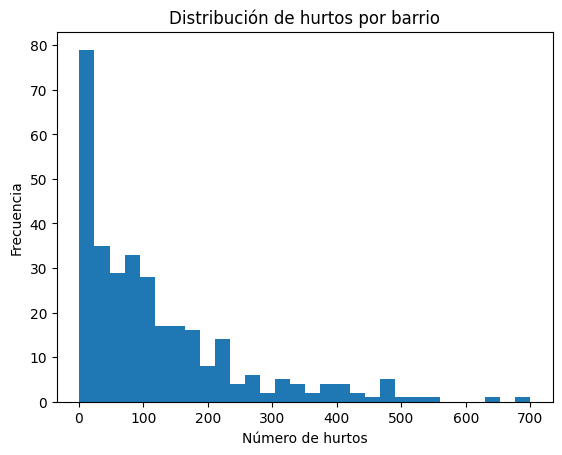

In [20]:
plt.hist(resumen["hurtos"], bins=30)
plt.title("Distribución de hurtos por barrio")
plt.xlabel("Número de hurtos"); plt.ylabel("Frecuencia")
plt.show()

In [ ]:
# Unir resultados al shapefile original
barrios_hurtos = barrios.merge(resumen, on="nombre", how="left").fillna({"hurtos": 0})

In [22]:
barrios_hurtos.head()

,OBJECTID,codigo,nombre,identificacion,limitecomunacorregimientoid,limitemunicipioid,subtipo_barriovereda,fecha_actualizacion,Shape_Length,Shape_Area,geometry,hurtos
0,1,Inst_15,U.P.B,Inst_15,11,001,1,1418774400000,1872.110579,216519.300817,"POLYGON ((-75.58911 6.24447, -75.58922 6.24449...",11
1,2,Inst_18,Cerro Nutibara,Inst_18,16,001,1,1418774400000,2840.275369,399158.946697,"POLYGON ((-75.57669 6.23733, -75.57690 6.23729...",32
2,3,0610,Mirador del Doce,0610,06,001,1,1418774400000,1336.347402,64822.378858,"POLYGON ((-75.58450 6.30520, -75.58460 6.30520...",14
3,4,1620,El Nogal-Los Almendros,1620,16,001,1,1418774400000,3072.101126,248370.770989,"POLYGON ((-75.59551 6.23662, -75.59550 6.23663...",264
4,5,0612,El Triunfo,0612,06,001,1,1418774400000,1730.001961,117069.306574,"POLYGON ((-75.58618 6.31007, -75.58620 6.31007...",16


(-75.731686367396, -75.45947841152837, 6.152305691040686, 6.38547045910226)

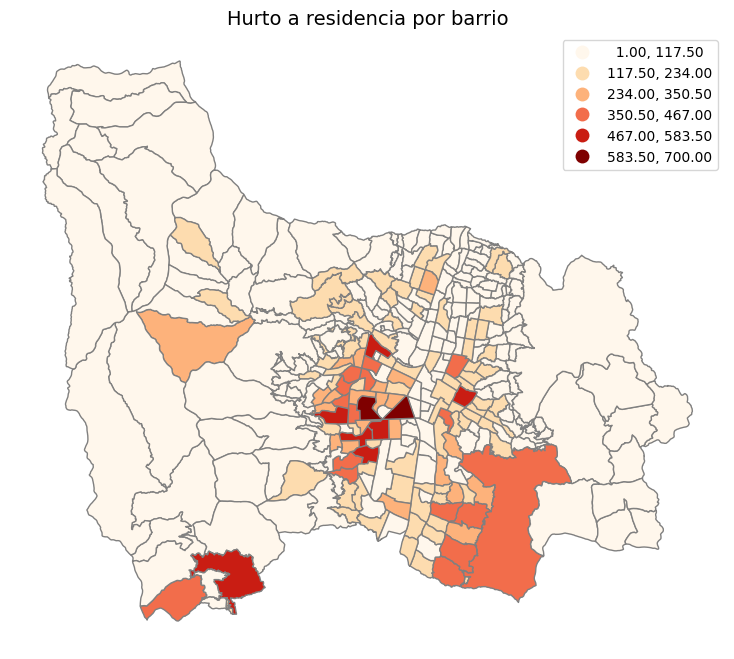

In [27]:

# Graficar
ax = barrios_hurtos.plot(
    column="hurtos",
    cmap="OrRd", # paleta naranja–roja
    scheme="EqualInterval", # Clasificación por cuantiles
    k=6, # número de intervalos o clases
    legend=True,
    figsize=(10, 8),
    edgecolor="gray",
)
ax.set_title("Hurto a residencia por barrio", fontsize=14)
ax.axis("off")

Población - Proyecciones (2018-2030) por comuna y corregimiento
https://www.medellin.gov.co/giscatalogacion/srv/spa/catalog.search#/metadata/ec0cb4a3-5774-4eb3-8cd4-d0b4ec1c6682